In [4]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

In [2]:
import common

try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [9]:
LOANS_INCOME_CSV = DATA / 'loans_income.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'

# Population vs sample

<bound method _AxesBase.set_position of <Axes: >>

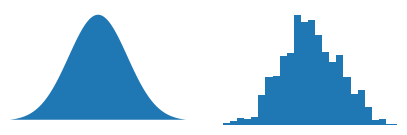

In [7]:
np.random.seed(2024)

x = np.linspace(-3,3,300)
x_sample = stats.norm.rvs(size=1000)

fig, axes = plt.subplots(ncols=2, figsize=(5, 1.5))

ax = axes[0]
ax.fill(x, stats.norm.pdf(x))
ax.set_axis_off()
ax.set_xlim(-3, 3)

ax = axes[1]
ax.hist(x_sample, bins=30)
ax.set_axis_off()
ax.set_xlim(-3, 3)
ax.set_position

# Sampling Distribution of a Statistic

In [30]:
loan_df = pd.read_csv(LOANS_INCOME_CSV) # this is the population
loan_df.head()

,x
0,67000
1,52000
2,100000
3,78762
4,37041


In [20]:
loan_ser = loan_df.squeeze('columns') # convert to series
sampe_data = pd.DataFrame({
    'income': loan_ser.sample(1000),
    'type':'Data'
})

sample_mean_05 = pd.DataFrame({
    'income': [loan_ser.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5 samples'
})

sample_mean_20 = pd.DataFrame({
    'income': [loan_ser.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20 samples'
})

results = pd.concat([sampe_data, sample_mean_05, sample_mean_20])
results.head()

,income,type
46664,56800.0,Data
42557,38000.0,Data
47851,71000.0,Data
29941,80000.0,Data
38501,70000.0,Data


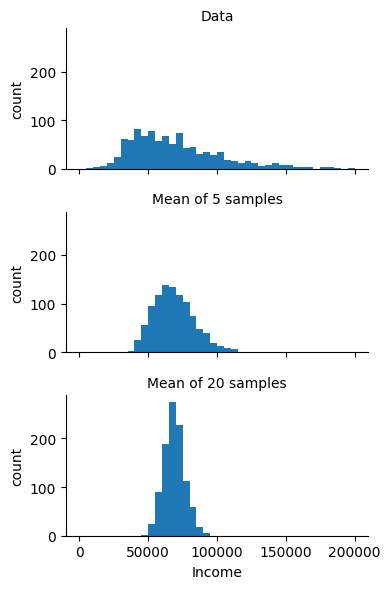

In [21]:
g = sns.FacetGrid(results, col='type', col_wrap=1, height=2, aspect=2)
g.map(plt.hist, 'income', range=[0,200000], bins=40)
g.set_axis_labels('Income','count')
g.set_titles('{col_name}')
plt.tight_layout()
plt.show()

# Bootstrap

In [24]:
# resample sample

from sklearn.utils import resample

np.random.seed(2024)
sample = loan_df.sample(5).squeeze()
print(sample)
bootstraped_sample = resample(sample)
print(bootstraped_sample)

16441    34000
26819    58000
9242     68000
16234    74000
19184    42000
Name: x, dtype: int64
9242     68000
26819    58000
19184    42000
16441    34000
26819    58000
Name: x, dtype: int64


In [34]:
results = []

from sklearn.utils import resample

loan_ser = loan_df.squeeze()

import math
for r in range(1000): # R = 1000
    sample = resample(loan_ser) # resample is used for bootstraping where it returns a new sample of the same size (This is done using sampling with replacement)
    results.append(sample.median())

results_ser = pd.Series(results)
print('Bootstrap Stats\n')
print(f'Median of original : {loan_ser.median()}') # original data distribution
print(f'Bias = {results_ser.mean() - loan_ser.median()}')
print(f'Standard Error = {results_ser.std()}')

Bootstrap Stats

Median of original : 62000.0
Bias = -82.67949999999837
Standard Error = 233.8826160873395


<Axes: ylabel='Frequency'>

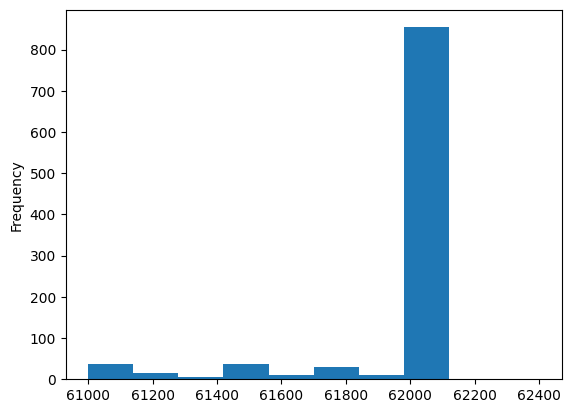

In [35]:
results_ser.plot.hist()

Above distribution shows that assumption of normality is only limited till CLT

# Confidence Interval

In [36]:
loan_df.head()

,x
0,67000
1,52000
2,100000
3,78762
4,37041


In [37]:
loan_income = loan_df.squeeze()

np.random.seed(2024)

# Lets take a sample of 20 items
sample_20 = resample(loan_income, n_samples=20, replace=False)
print(sample_20) 

16441     34000
26819     58000
9242      68000
16234     74000
19184     42000
34763     76000
36781     50000
9082      51200
39944     82000
38247    118000
23504     42000
42162    150000
42993     93000
12782    134000
48753     43200
14051     94000
47542     50000
22530     43000
5817      97500
296       52000
Name: x, dtype: int64


In [38]:
# mean of the sample 
print(sample_20.mean())

72595.0


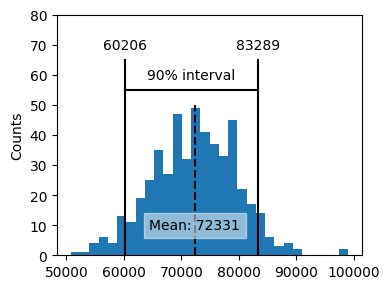

In [42]:
results_list = []
for r in range(500):
    sample = resample(sample_20) # bootstraping
    results_list.append(sample.mean())

results = pd.Series(results_list)

confidence_interval = list(results.quantile([0.05,0.95])) # 90% confience interval

ax = results.plot.hist(bins=30,figsize=(4,3))
ax.plot(confidence_interval,[55,55],color='black')

for x in confidence_interval:
    ax.plot([x, x], [0, 65], color='black')
    ax.text(x, 70, f'{x:.0f}', horizontalalignment='center', verticalalignment='center')
ax.text(sum(confidence_interval) / 2, 60, '90% interval', horizontalalignment='center', verticalalignment='center')

mean_income = results.mean()
ax.plot([mean_income, mean_income], [0, 50], color='black', linestyle='--')
ax.text(mean_income, 10, f'Mean: {mean_income:.0f}',
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.5),
        horizontalalignment='center', verticalalignment='center')
ax.set_ylim(0, 80)
ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()
